In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15

cosmo = Planck15
H0 =  cosmo.H0.to('1/s').value

In [3]:
def PTA_noise(f):
    DT_inverse = 20/(365*24*3600) #Hz
    s = 100 * 1e-9 #s
    return 2* (s**2)/DT_inverse

def Seff(f):
    return PTA_noise(f) * 12 * (np.pi**2) * f**3

def Omega_eff(f):
    H0 = 67/3 * 1e-18 #1/s
    return 4 * np.pi * np.pi * f**3 * Seff(f) / (3* H0**2)

Text(0.5, 1.0, 'Effective Strain vs Frequency')

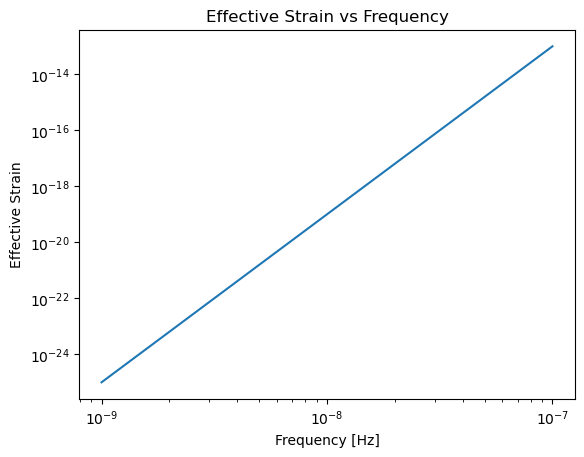

In [4]:
f = np.logspace(-9, -7, 1000)

plt.loglog(f, Omega_eff(f))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Effective Strain')
plt.title('Effective Strain vs Frequency')

In [ ]:

def HellingsDowns(catalogue1, catalogue2):
    alpha = np.arccos(np.dot(catalogue1, catalogue2)/ (np.linalg.norm(catalogue1) * np.linalg.norm(catalogue2)))
    arg = (1-np.cos(alpha))/2
    return (3/2)*arg*np.log(arg) - arg/4 + 0.5

def orf_pta_single(catalogue1, catalogue2, f):
    return HellingsDowns(catalogue1, catalogue2)/((2*np.pi*f)**2 *3)

def orf_pta(catalogue, f): # for a network of pulsar
    orf =  0
    for i in range(len(catalogue)):
        for j in range(i+1, len(catalogue)):
            orf += orf_pta_single(catalogue[i], catalogue[j], f)
    return orf
 

In [ ]:
def PTA_Pn():
    DT_inverse = 20/(365*24*3600) #Hz
    s = 100 * 1e-9 #s
    return 2* (s**2)/DT_inverse


def PTA_Sn(f):
    f = np.asarray(f) # Ensure f is a NumPy array
    mask = f >= 8e-9 # Create a boolean mask where True indicates elements greater than or equal to 8e-9
    return np.where(mask, PTA_Pn() * 12 * (np.pi**2) * f**2, 1) # Apply the mask to the result

def PTA_Seff(f, catalogue):
    hd = 0
    for i in range(len(catalogue)):
        for j in range(i+1, len(catalogue)):
            hd += (HellingsDowns(catalogue[i], catalogue[j]))**2
    return hd*PTA_Sn(f)

def PTA_Omegaeff(f, catalogue, om_load):
    if om_load==False:
        return 10 * np.pi * np.pi * f**3 * PTA_Seff(f, catalogue) / (3* (H0**2))
    else:
        return np.genfromtxt('/home/ilaria/Desktop/morfeus/pypack/Omegaeff.txt', unpack=True, usecols=1)

def Omega_beta_PTA(f_range, snr, Tobs, beta, catalogue, om_load):
    Tobs = Tobs*365*24*3600
    fref = 1e-8
    integrand = lambda f : ((f/fref)**(2*beta))/ (PTA_Omegaeff(f, catalogue, om_load)**2)
    integral = np.trapz(integrand(f_range), f_range)
    return snr / np.sqrt(2*Tobs*integral)

def Omega_GW_PTA(f_i,  beta, fref, snr, Tobs, catalogue, om_load):
    return Omega_beta_PTA(f_i, snr, Tobs, beta, catalogue, om_load) * ((f_i/fref)**(beta))

def all_Omega_GW_PTA(f_i, snr, Tobs, beta_min, beta_max, catalogue, om_load):
    beta = np.linspace(beta_min, beta_max, 100)
    fref = 1e-8
    Omega = np.zeros((len(beta), len(f_i)))
    for i, beta_val in enumerate(beta):
        Omega[i, :] = Omega_GW_PTA(f_i, beta_val, fref, snr, Tobs, catalogue, om_load)
    return beta, Omega

def find_pls_PTA(f_i, snr, Tobs, beta_min, beta_max, catalogue, om_load):

    beta, Omega = all_Omega_GW_PTA(f_i, snr, Tobs, beta_min, beta_max, catalogue, om_load)
    pls = np.max(Omega, axis=0)
    return pls